# 📘 Modeling: Student Performance and Risk Prediction

This notebook covers the modeling phase of the student data performance project. It includes predictive modeling for student grades and classification of at-risk students, along with model evaluation and selection.

In this notebook, we:
- Develop a regression model to predict student GPA
- Derive a binary risk label (`risk_flag`) based on GPA
- Train a classificication model to identify at-risk students
- Evaluate and compare model performance
- Tuning top models
- Save models for deployment

In [ ]:
# 1. Load packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error,
                             accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score)
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Data Load and Split

In [27]:
# 1. Load Processed Data & Pipeline
file_path = "../data/feature_engineered_student_data.csv"
df = pd.read_csv(file_path)
pipeline = joblib.load('../models/student_data_preprocessing_pipeline.pkl')

In [28]:
# 3. Prepare Targets and Features
X = df.drop(columns=['risk_flag', 'gpa', 'gradeclass'])

# Separate targets for regression and classification
y_reg = df['gpa']
y_cls = df['risk_flag']

In [31]:
# # # 4. Process Features (Apply the pipeline to the features)
# X_transformed = pipeline.transform(X)

# # # Get proper feature names from pipeline
# feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# # Convert to DataFrame for better readability and model compatibility
# X_transformed_df = pd.DataFrame(X_transformed, columns=feature_names)

In [32]:
# Split data for GPA regression 
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
# Split data for At-Risk classification
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X, y_cls, test_size=0.2, random_state=42)

Train Models

In [34]:
# Initialize Models
reg_models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42)
}
for name, model in reg_models.items():
    model.fit(X_train_reg, y_train_reg)
    y_pred = model.predict(X_test_reg)
    print(f"{name} R2: {r2_score(y_test_reg, y_pred):.4f}, "
          f"MAE: {mean_absolute_error(y_test_reg, y_pred):.4f}, "
          f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, y_pred)):.4f}")

LinearRegression R2: 0.9533, MAE: 0.1553, RMSE: 0.1966
RandomForestRegressor R2: 0.9275, MAE: 0.1896, RMSE: 0.2448
XGBRegressor R2: 0.9315, MAE: 0.1874, RMSE: 0.2380


Classification using Predicted GPA

In [35]:
# Use best model to predict GPA
best_reg_model = reg_models['LinearRegression']  # or the best one
y_pred_gpa = best_reg_model.predict(X)

# Convert predicted GPA to risk_flag
y_pred_cls = (y_pred_gpa < 2.0).astype(int)

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      1118
           1       0.95      0.94      0.95      1274

    accuracy                           0.95      2392
   macro avg       0.95      0.95      0.95      2392
weighted avg       0.95      0.95      0.95      2392

[[1060   58]
 [  72 1202]]


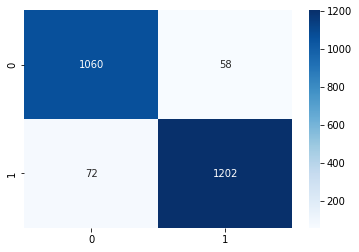

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_cls, y_pred_cls))
print(confusion_matrix(y_cls, y_pred_cls))
sns.heatmap(confusion_matrix(y_cls, y_pred_cls), annot=True, fmt='d', cmap='Blues');

Save Best Model

In [40]:
# Save best regression model
joblib.dump(best_reg_model, "../models/lr_student_grade_model.pkl")
print("✅ Best Regression Model Saved!")

✅ Best Regression Model Saved!
